In [ ]:
import yaml
 
try:
    with open("../config.yaml", "r") as file:
        config = yaml.safe_load(file)
except:
    print("Yaml configuration file not found!")

In [1]:
import pandas as pd

df = pd.read_csv("../data/clean/alzheimers_top5.csv")
df

,FunctionalAssessment,ADL,MemoryComplaints,MMSE,BehavioralProblems,Diagnosis
0,6.518877,1.725883,0,21.463532,0,0
1,7.118696,2.592424,0,20.613267,0,0
2,5.895077,7.119548,0,7.356249,0,0
3,8.965106,6.481226,0,13.991127,1,0
4,6.045039,0.014691,0,13.517609,0,0
...,...,...,...,...,...,...
2144,0.238667,4.492838,0,1.201190,0,1
2145,8.687480,9.204952,0,6.458060,1,1
2146,1.972137,5.036334,0,17.011003,0,1
2147,5.173891,3.785399,0,4.030491,0,1


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt

Baseline Accuracy (using log_reg.score): 85.81%

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.94      0.89       267
           1       0.88      0.73      0.80       163

    accuracy                           0.86       430
   macro avg       0.86      0.83      0.84       430
weighted avg       0.86      0.86      0.86       430



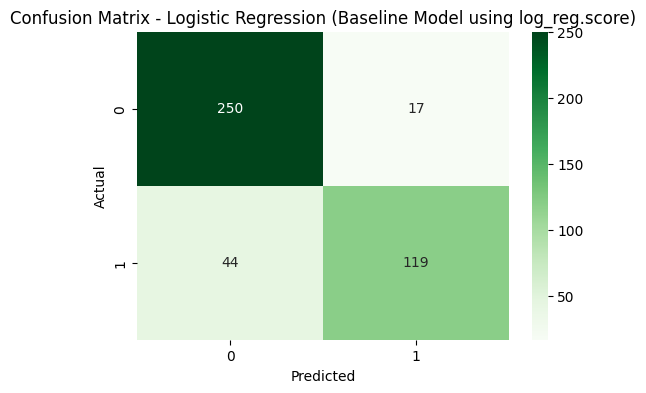

In [6]:
# ================================================
# BASELINE MODEL - LOGISTIC REGRESSION
# ================================================
# 1. Separate features (X) and target (y)
X = df.drop(columns=["Diagnosis"])
y = df["Diagnosis"]
# 2. Split data into training and testing sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)
# 3. Standardize the features (important for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# 4. Initialize a simple Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, random_state=0)
# 5. Train the model
log_reg.fit(X_train_scaled, y_train)
# 6. Evaluate accuracy using log_reg.score (similar to knn.score)
accuracy = log_reg.score(X_test_scaled, y_test)
print(f"Baseline Accuracy (using log_reg.score): {accuracy * 100:.2f}%")
# 7. Generate predictions for detailed metrics
y_pred = log_reg.predict(X_test_scaled)
# 8. Show detailed performance report
print("\nClassification Report:\n", classification_report(y_test, y_pred))
# 9. Display confusion matrix as a heatmap
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix - Logistic Regression (Baseline Model using log_reg.score)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Cross-Validation Scores: [0.84883721 0.84302326 0.85755814 0.83430233 0.82798834]
Mean CV Accuracy: 0.8423418536849955
Fitting 5 folds for each of 51 candidates, totalling 255 fits

Best Parameters Found: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Cross-Validation Accuracy: 0.8429266390941758

Test Accuracy: 0.8534883720930233

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.94      0.89       267
           1       0.88      0.71      0.78       163

    accuracy                           0.85       430
   macro avg       0.86      0.82      0.84       430
weighted avg       0.86      0.85      0.85       430



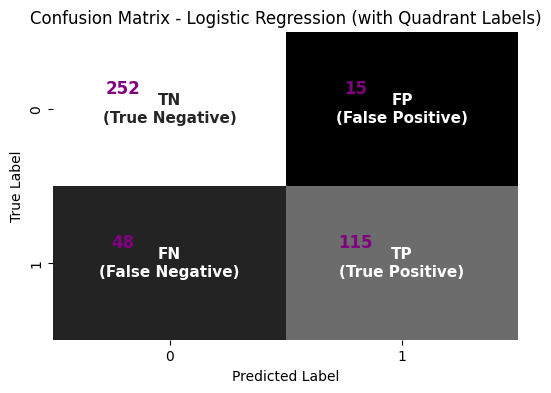

In [30]:
# ================================================
# LOGISTIC REGRESSION - CLEAN GRID SEARCH
# Compatible solver/penalty combinations
# ================================================
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
# 3. Separate features and target
X = df.drop(columns=["Diagnosis"])
y = df["Diagnosis"]
# 4. Split data into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)
# 5. Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# ================================================
# STEP 1 — Cross-Validation (5 folds)
# ================================================
log_reg = LogisticRegression(max_iter=1000, random_state=0)
cv_scores = cross_val_score(log_reg, X_train_scaled, y_train, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())
# ================================================
# STEP 2 — Grid Search (Valid parameter combos)
# ================================================
param_grid = [
    # lbfgs supports only l2 or None
    {'solver': ['lbfgs'], 'penalty': ['l2'], 'C': [0.01, 0.1, 1, 10, 100]},
    # liblinear supports l1 and l2
    {'solver': ['liblinear'], 'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10, 100]},
    # saga supports l1, l2, elasticnet
    {'solver': ['saga'], 'penalty': ['l1', 'l2', 'elasticnet'], 'l1_ratio': [0.0, 0.5, 1.0], 'C': [0.01, 0.1, 1, 10]}
]
grid = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=0),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    error_score='raise'  # raises if an invalid combo somehow slips in
)
grid.fit(X_train_scaled, y_train)
print("\nBest Parameters Found:", grid.best_params_)
print("Best Cross-Validation Accuracy:", grid.best_score_)
# ================================================
# STEP 3 — Evaluate Tuned Model on Test Set
# ================================================
best_log_reg = grid.best_estimator_
y_pred = best_log_reg.predict(X_test_scaled)
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
# ================================================
# STEP 4 — Confusion Matrix with Labels
# ================================================
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Create labeled annotations for each cell
labels = [
    ["TN\n(True Negative)", "FP\n(False Positive)"],
    ["FN\n(False Negative)", "TP\n(True Positive)"]
]
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=labels, fmt='', cmap="grey", cbar=False, annot_kws={"fontsize":11, "weight":"bold"})
plt.title("Confusion Matrix - Logistic Regression (with Quadrant Labels)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
# Optional: Show numeric values on top of text
for i in range(2):
    for j in range(2):
        plt.text(j + 0.3, i + 0.3, f"\n{cm[i, j]}", color="purple", ha='center', va='center', fontsize=12, weight="bold")
plt.show()